<center>
    
# [Компьютерное зрение](https://cogmodel.mipt.ru/wiki/index.php/%D0%9A%D0%BE%D0%BC%D0%BF%D1%8C%D1%8E%D1%82%D0%B5%D1%80%D0%BD%D0%BE%D0%B5_%D0%B7%D1%80%D0%B5%D0%BD%D0%B8%D0%B5)

## <center> Семинар 1 - Основы работы с OpenCV, фильтр Байера, сжатие/расжатие изображений

<a target="_blank" href="https://colab.research.google.com/github/alexmelekhin/cv_course_2023/blob/main/seminars/seminar_01/Seminar_01.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

***

In [1]:
from pathlib import Path

import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
IMG_PATH = "data/Lenna_test_image.jpeg"

if not Path(IMG_PATH).exists():
    !git clone https://github.com/alexmelekhin/cv_course_2023.git
    !mv cv_course_2023/seminars/seminar_01/data .

Cloning into 'cv_course_2023'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 65 (delta 19), reused 56 (delta 11), pack-reused 0
Unpacking objects: 100% (65/65), 8.35 MiB | 6.45 MiB/s, done.


# Считывание изображений

Считать изображение с диска можно с помощью функции imread:

In [3]:
img = cv2.imread(IMG_PATH)

In [4]:
img.shape

(512, 512, 3)

отобразим изображение:

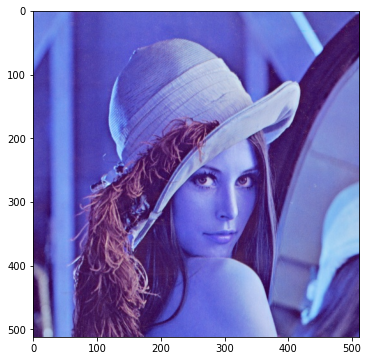

In [5]:
plt.figure(figsize=[6, 6])
plt.imshow(img)

Как видно, цвета изображения неправильные. Это потому, что функция imread считывает изображения в формате BGR (blue, green, red). Чтобы перейти к более привычному представлению RGB (reg, green, blue), который ожидает matplotlib, можно воспользоваться встроенной функцией cvtColor:

In [6]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

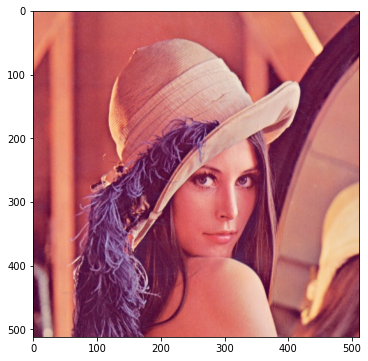

In [7]:
plt.figure(figsize=[6, 6])
plt.imshow(img_rgb)

### Что это за изображение?

> The Lenna (or Lena) picture is one of the most widely used standard test images used for compression algorithms.

[The Lenna Story - www.lenna.org](http://www.lenna.org/)

# Работа с изображением

Загруженное цветное изображение является обычным numpy массивом с тремя размерностями, каждый элемент которого - целое беззнаковое 8-ми битное число, представляющее квантованную на 256 уровней интенсивность одного из цветов (RGB: 0 - красный, 1 - зеленый, 2 - синий):

In [8]:
print('type(img_rgb) = ', type(img_rgb))
print('img_rgb.shape = ', img_rgb.shape)
print('img_rgb.dtype = ', img_rgb.dtype)

type(img_rgb) =  <class 'numpy.ndarray'>
img_rgb.shape =  (512, 512, 3)
img_rgb.dtype =  uint8


Над изображением можно выполнять те же операции, что и над обычным массивом. Например, рассчитать статистики:

In [9]:
print('img_rgb.min() = ', img_rgb.min())
print('img_rgb.max() = ', img_rgb.max())
print('img_rgb.mean() = ', img_rgb.mean())
print('img_rgb.std() = ', img_rgb.std())
print('np.median(img_rgb) = ', np.median(img_rgb))

img_rgb.min() =  0
img_rgb.max() =  255
img_rgb.mean() =  128.22198232014975
img_rgb.std() =  58.942859735329606
np.median(img_rgb) =  119.0


присвоить какое-либо значение блоку(пикселю):

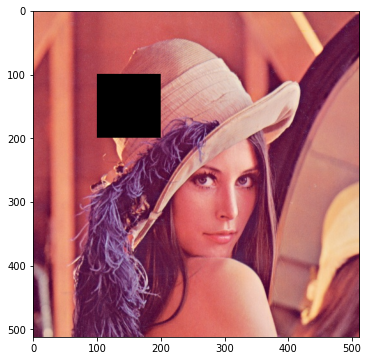

In [10]:
img_rgb_2 = img_rgb.copy()
img_rgb_2[100:200, 100:200] = 0

plt.figure(figsize=[6, 6])
plt.imshow(img_rgb_2)

прибавить какое-либо значение блоку(пикселю):

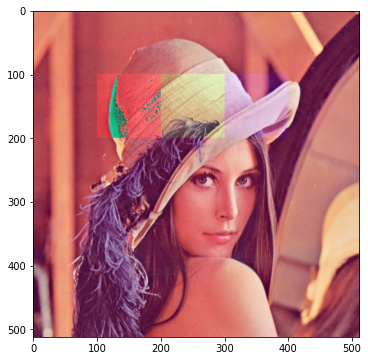

In [11]:
img_rgb_3 = img_rgb.copy()
img_rgb_3[100:200, 100:200, 0] += 40
img_rgb_3[100:200, 200:300, 1] += 40
img_rgb_3[100:200, 300:400, 2] += 40

plt.figure(figsize=[6, 6])
plt.imshow(img_rgb_3)

## Вопрос 1

- Что произошло с цветами на изображении img_rgb_3? Почему так произошло?

    **Ответ: произошло переполнение типа данных**

## Упражнение 1: BGR -> RGB
Реализуйте функцию преобразования изображения в формате BGR в формат RGB

In [12]:
def convert_color_bgr_to_rgb(img_bgr: np.ndarray) -> np.ndarray:
    return img[...,::-1]

In [13]:
assert((img_rgb == convert_color_bgr_to_rgb(img)).all())

## Упражнение 2: Изменение яркости
Одним из простейших преобразований изображения является изменение уровня яркости, задаваемое следующим образом:
$$
f'(x, y) = \alpha f(x, y) + \beta
$$

В данном упражнении необходимо реализовать это преобразование, а также исследовать работу при различных значениях параметров. 

- Какую физическую интерпретацию можно дать этому преобразованию?

    **Ответ: линейное преобразование(смещение) Например, затемнение-осветление** 

In [41]:
def change_intensity(img: np.ndarray, alpha: float = 1, beta: float = 0) -> np.ndarray:
    output_array = np.round(alpha * img + beta)
    return np.clip(output_array, 0, 255).astype(np.uint8)

In [42]:
alpha = 1.2
beta = 10

img_out_cv = np.zeros_like(img_rgb)
cv2.convertScaleAbs(img_rgb, img_out_cv, alpha, beta)

img_out_my = change_intensity(img_rgb, alpha, beta)

assert((img_out_cv == img_out_my).all())

## Упражнение 3: Смешивание изображений $\alpha - blend$

Другим простым преобразованием является смешивание двух изображений, задаваемое как:

$$
    f'(x, y) = \alpha f_1(x, y) + (1 - \alpha) f_2(x, y)
$$

Реализуйте данную операцию и продеменстрируйте ее работу на примере. Вы можете использовать изображение `data/opencv_logo.jpeg` или загрузить свое.

- Приведите примеры, для каких задач может понадобиться данная операция. 

    **Ответ: аугментация данных, соединение стилей, выделить область с помощью маски, нанесение водяного знака**

- Как она может быть обобщена на большее количество изображений? Выпишите формулу.

    **Ответ:**
$$
    f'(x, y) = \sum^n_{i=1} \alpha_i f_i(x, y),  \\  
    где \sum^n_{i=1} \alpha_i = 1
$$

In [43]:
def blend_two_images(img_1: np.ndarray, img_2: np.ndarray, alpha: float = 0.5) -> np.ndarray:
    output_array = np.round(alpha * img_1 + (1 - alpha) * img_2)
    return np.clip(output_array, 0, 255).astype(np.uint8)

In [46]:
IMG_PATH = "/content/data/opencv_logo.jpeg"
img2 = cv2.imread(IMG_PATH)
img2.shape

(512, 512, 3)

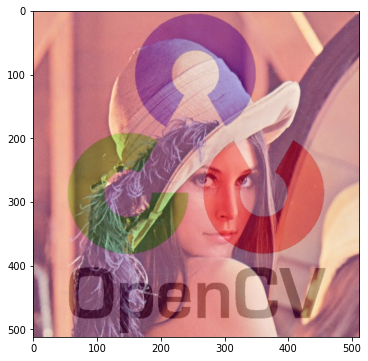

In [49]:
plt.figure(figsize=[6, 6])
img_blend = blend_two_images(img_rgb, img2, alpha= 0.75)
plt.imshow(img_blend)

# Нанесение текста и фигур

С помощью OpenCV можно добавить дополнительные элементы на изображение, такие как текст, простые геометрические фигуры и т.д. (см. https://docs.opencv.org/4.x/dc/da5/tutorial_py_drawing_functions.html)

In [50]:
TEXT = 'Lenna 0.99'
UL_CORNER = (200, 200)  # верхний левый угол
FONT = 0                # шрифт
SCALE = 1               # размер
COLOR = (0, 255, 0)     # цвет - зеленый
THICKNESS = 2           # толшина линий

img_rgb_4 = img_rgb.copy()

cv2.putText(img_rgb_4, TEXT, UL_CORNER, FONT, SCALE, COLOR, THICKNESS)
cv2.rectangle(img_rgb_4, UL_CORNER, (370, 400), COLOR, THICKNESS)
None

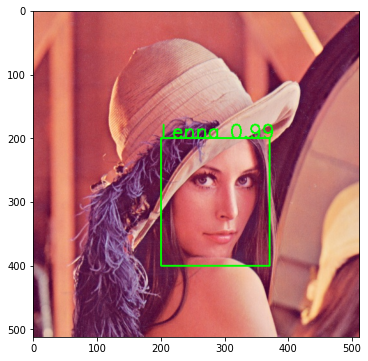

In [51]:
plt.figure(figsize=[6, 6])
plt.imshow(img_rgb_4)

## Вопрос 2

- Зачем может понадобиться рисовать на изображении?

    **Ответ отмечать детектируемые обекты и их подписывать, выделять дефекты сегментации и детекции**:

# Фильтр Байера

Сырые изображения, приходящие с камеры, являются байеризованными. Они представлены в виде двумерного массива, где отдельные пиксели кодируют интенсивность синего, зеленого, красного цветов. 

![Фильтр Байера](https://github.com/alexmelekhin/cv_course_2023/blob/main/seminars/seminar_01/data/bayer.jpeg?raw=1)

OpenCV позволяет преобразовывать такие изображения в привычные трехканальные изображения. Этот процесс называется дебайеризация или демозаикинг.


## Вопрос 3

- Почему на фильтре Байера зеленых пикселей в 2 раза больше чем синих или красных?

    **Ответ: генетически заложено, человек лучще различает зеленый**

- Можно ли сделать иначе?

    **Ответ:да**

## Упражнение 4: Байеризация

Преобразуйте RGB изображение в байеризованное, как на картинке выше (в формате BGGR), разделив три канала на четыре смежных пикселя

In [60]:
img_rgb[::2, ::2, 0].shape

(256, 256)

In [73]:
def rgb_to_bayer(img_rgb: np.ndarray) -> np.ndarray:
    bayer = np.zeros((img_rgb.shape[0], img_rgb.shape[1]), dtype=np.uint8)
    bayer[::2, ::2] = img_rgb[::2, ::2, 2]  # Blue channel
    bayer[1::2, ::2] = img_rgb[1::2, ::2, 1]  # Green channel
    bayer[1::2, 1::2] = img_rgb[1::2, 1::2, 0]  # Red channel
    bayer[::2, 1::2] = img_rgb[::2, 1::2, 1]
    return bayer 

посмотрим на кусочек изображения вблизи:

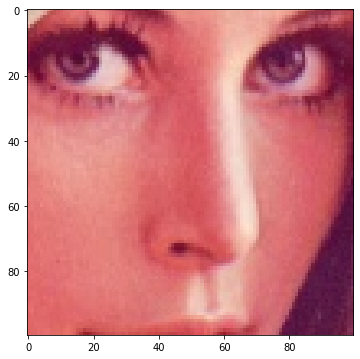

In [74]:
plt.figure(figsize=[6, 6])
plt.imshow(img_rgb[250:350, 250:350])

Получим его байеризованную версию, изображение должно содержать характерный мазайчный узор:

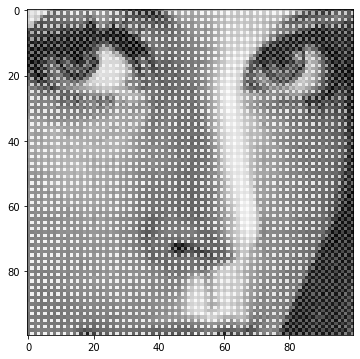

In [78]:
img_bayer = rgb_to_bayer(img_rgb)
plt.figure(figsize=[6, 6])
plt.imshow(img_bayer[250:350, 250:350], cmap='Greys_r')

Для дебайеризации можно воспользоваться функцией из OpenCV:

In [79]:
img_debayer = cv2.cvtColor(img_bayer, cv2.COLOR_BayerBGGR2RGB)

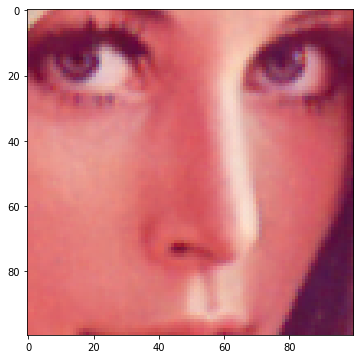

In [80]:
plt.figure(figsize=[6, 6])
plt.imshow(img_debayer[250:350, 250:350])

Если все сделано верно, то дебайеризованное изображение будет похоже на исходное. Однако точного совпадения не будет. 

- Попытайтесь предположить, почему?

    **Ответ: потеря информации** 

# Сжатие/расжатие изображений

Изображения в формате JPEG являются сжатыми изображениями и на диске могут занимать существенно меньше места, чем после загрузки в оперативную память. Чтобы загрузить изображения в сжатом формате, можно просто прочитать файл в бинарном режиме:

In [82]:
with open(IMG_PATH, 'rb') as f:
    img_bytes = f.read()

In [83]:
print('type(img_bytes) = ', type(img_bytes))

type(img_bytes) =  <class 'bytes'>


Считанные данные нужно преобразовать в массив байт для возможности дальнейшего расжатия:

In [84]:
img_buf = np.asarray(bytearray(img_bytes), dtype=np.uint8)

In [85]:
img_buf.shape, img_buf.dtype

((42116,), dtype('uint8'))

In [86]:
img_buf_size = np.array(img_buf.shape).prod()
print('Размер сжатого изображения: {:.3f} МБ'.format(img_buf_size / 1024 / 1024))

Размер сжатого изображения: 0.040 МБ


Как видим, в сжатом виде изображение занимает мало места и в оперативной памяти. Разожмем его с помощью средств OpenCV:

In [87]:
img = cv2.imdecode(img_buf, cv2.IMREAD_COLOR)

In [88]:
img.shape, img.dtype

((512, 512, 3), dtype('uint8'))

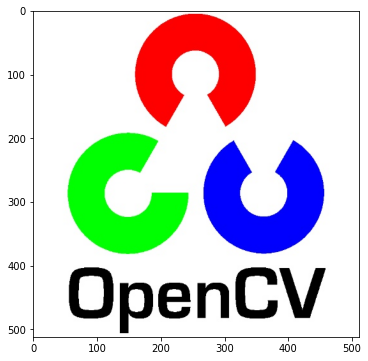

In [89]:
plt.figure(figsize=[6, 6])
plt.imshow(img[:, :, ::-1])

In [90]:
img_size = np.array(img.shape).prod()
print('Размер изображения: {:.3f} МБ'.format(img_size / 1024 / 1024))

Размер изображения: 0.750 МБ


Как видим в несжатом представлении изображение занимает существенно больше памяти. Рассчитаем коэффициент сжатия:

In [91]:
print('Коэффициент сжатия: {:.1f}'.format(img_size / img_buf_size))

Коэффициент сжатия: 18.7


Изображение можно сжать обратно следующим образом:

In [92]:
ok, img_buf_2 = cv2.imencode('.jpg', img, (cv2.IMWRITE_JPEG_QUALITY, 10))

In [93]:
img_buf_2_size = np.array(img_buf_2.shape).prod()
print('Размер сжатого изображения: {:.3f} МБ'.format(img_buf_2_size / 1024 / 1024))

Размер сжатого изображения: 0.009 МБ


Алгоритм сжатия определяется указанным расширением, кроме того имеет различные параметры: https://vovkos.github.io/doxyrest-showcase/opencv/sphinxdoc/enum_cv_ImwriteFlags.html. Наиболее используемым является качество сжатия.

Декодируем сжатое с качеством 10 изображение:

In [94]:
img_2 = cv2.imdecode(img_buf_2, cv2.IMREAD_COLOR)

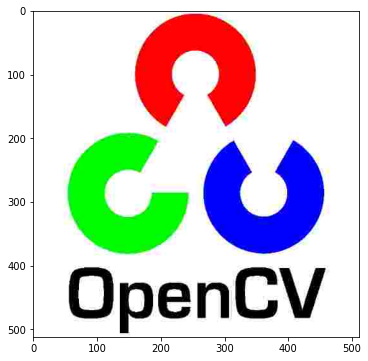

In [95]:
plt.figure(figsize=[6, 6])
plt.imshow(img_2[:, :, ::-1])

## Вопрос 4

- Зачем может понадобиться хранить в оперативной памяти сжатые изображения?

    **Ответ: быстрее передача данных и эффективное хранение на диске**